## Work
1. 請比較使用不同層數以及不同 Dropout rate 對訓練的效果
2. 將 optimizer 改成使用 Adam 並加上適當的 dropout rate 檢視結果

In [3]:
!"C:\Program Files\NVIDIA Corporation\NVSMI\nvidia-smi.exe"

Sun Mar 31 23:14:25 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 399.24                 Driver Version: 399.24                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 970    WDDM  | 00000000:01:00.0  On |                  N/A |
| 34%   29C    P0    42W / 250W |    279MiB /  4096MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import os
import keras
from keras.regularizers import l1, l2, l1_l2
import tensorflow as tf

from numba import cuda
cuda.select_device(0)
cuda.close()

import itertools
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [4]:
train, test = keras.datasets.cifar10.load_data()

In [5]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [6]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [7]:
def build_mlp(drop_ratio, input_shape, output_units=y_train.shape[-1],
              n_layers=4, num_neurons=[512, 256, 128, 64, 32, 16]):
  

    input_layer = keras.layers.Input(input_shape)  

    for i, n_units in enumerate(num_neurons[:n_layers]):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation='relu',
                                   name='hidden_layers'+str(i+1))(input_layer)

            x = keras.layers.Dropout(drop_ratio)(x)

        else:

            x = keras.layers.Dense(units=n_units,activation='relu',
                                   name='hidden_layers'+str(i+1))(x)

            x = keras.layers.Dropout(drop_ratio)(x)

    output_layer = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)

    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    
    return model

In [12]:
## 超參數設定
LEARNING_RATE = 1e-3
OPTIMIZER = 'Adam'
EPOCHS = 50
BATCH_SIZE = 256
N_LAYERS = [5, 6]
DROPOUT = [0.2, 0.3, 0.4]

In [13]:
def model_fitting(drop_ratio, n_layers, learning_rate=LEARNING_RATE, optimizer=OPTIMIZER, 
                  epochs=EPOCHS, batch_size=BATCH_SIZE, input_shape=x_train.shape[1:]):

    keras.backend.clear_session()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    sess = tf.Session(config=config)

    
    model = build_mlp(drop_ratio=drop_ratio, n_layers=n_layers, input_shape=input_shape)
    model.summary()

    selector = {'SGD': keras.optimizers.SGD(lr=learning_rate, momentum=0.95, nesterov=True),
                'RMSprop': keras.optimizers.RMSprop(lr=learning_rate, rho=0.9, epsilon=None),
                'AdaGrad': keras.optimizers.Adagrad(lr=learning_rate, epsilon=None), 
                'Adam': keras.optimizers.Adam(lr=learning_rate, epsilon=None, amsgrad=True)}

    optimizer = selector.get(optimizer)

    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    history = model.fit(x_train, y_train, epochs=epochs, 
                        batch_size=batch_size,validation_data=(x_test, y_test), 
                        shuffle=False, verbose=2)

    sess.close()

    return history

In [14]:
results = {}

for drop_ratio, n_layers in itertools.product(DROPOUT, N_LAYERS):

    outcome = model_fitting(drop_ratio=drop_ratio, n_layers=n_layers)
    
    name_tag = f'Drop Ratio = {drop_ratio}, {n_layers} layers'
    results[name_tag] = {'train_loss': outcome.history['loss'],
                         'valid_loss': outcome.history['val_loss'],
                         'train_acc': outcome.history['acc'],
                         'valid_acc': outcome.history['val_acc']}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layers1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layers2 (Dense)       (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layers3 (Dense)       (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 5s - loss: 2.2222 - acc: 0.1372 - val_loss: 2.0862 - val_acc: 0.1906
Epoch 2/50
 - 4s - loss: 2.0981 - acc: 0.1788 - val_loss: 2.0004 - val_acc: 0.2369
Epoch 3/50
 - 4s - loss: 2.0284 - acc: 0.2188 - val_loss: 1.9357 - val_acc: 0.2709
Epoch 4/50
 - 4s - loss: 1.9765 - acc: 0.2376 - val_loss: 1.8968 - val_acc: 0.2753
Epoch 5/50
 - 4s - loss: 1.9481 - acc: 0.2466 - val_loss: 1.8800 - val_acc: 0.2816
Epoch 6/50
 - 4s - loss: 1.9272 - acc: 0.2551 - val_loss: 1.8537 - val_acc: 0.2886
Epoch 7/50
 - 4s - loss: 1.9155 - acc: 0.2631 - val_loss: 1.8556 - val_acc: 0.2935
Epoch 8/50
 - 4s - loss: 1.9028 - acc: 0.2712 - val_loss: 1.8419 - val_acc: 0.2936
Epoch 9/50
 - 4s - loss: 1.8913 - acc: 0.2758 - val_loss: 1.8278 - val_acc: 0.3105
Epoch 10/50
 - 4s - loss: 1.8861 - acc: 0.2774 - val_loss: 1.8182 - val_acc: 0.3019
Epoch 11/50
 - 4s - loss: 1.8752 - acc: 0.2822 - val_loss: 1.8086 - val_acc: 0.3104
Epoch 12/50
 - 4s - loss: 1.8684 - 

Epoch 25/50
 - 4s - loss: 1.8045 - acc: 0.3344 - val_loss: 1.7440 - val_acc: 0.3693
Epoch 26/50
 - 4s - loss: 1.8029 - acc: 0.3371 - val_loss: 1.7646 - val_acc: 0.3625
Epoch 27/50
 - 4s - loss: 1.7987 - acc: 0.3384 - val_loss: 1.7436 - val_acc: 0.3684
Epoch 28/50
 - 4s - loss: 1.7941 - acc: 0.3401 - val_loss: 1.7636 - val_acc: 0.3636
Epoch 29/50
 - 4s - loss: 1.7908 - acc: 0.3412 - val_loss: 1.7630 - val_acc: 0.3626
Epoch 30/50
 - 4s - loss: 1.7858 - acc: 0.3468 - val_loss: 1.7408 - val_acc: 0.3705
Epoch 31/50
 - 4s - loss: 1.7930 - acc: 0.3401 - val_loss: 1.7554 - val_acc: 0.3677
Epoch 32/50
 - 4s - loss: 1.7765 - acc: 0.3467 - val_loss: 1.7337 - val_acc: 0.3759
Epoch 33/50
 - 4s - loss: 1.7858 - acc: 0.3464 - val_loss: 1.7412 - val_acc: 0.3730
Epoch 34/50
 - 4s - loss: 1.7736 - acc: 0.3525 - val_loss: 1.7572 - val_acc: 0.3645
Epoch 35/50
 - 4s - loss: 1.7691 - acc: 0.3507 - val_loss: 1.7194 - val_acc: 0.3881
Epoch 36/50
 - 4s - loss: 1.7691 - acc: 0.3514 - val_loss: 1.7271 - val_acc:

Epoch 46/50
 - 4s - loss: 1.9767 - acc: 0.2344 - val_loss: 1.9885 - val_acc: 0.2286
Epoch 47/50
 - 4s - loss: 1.9777 - acc: 0.2359 - val_loss: 1.9500 - val_acc: 0.2433
Epoch 48/50
 - 4s - loss: 1.9752 - acc: 0.2358 - val_loss: 1.9990 - val_acc: 0.2270
Epoch 49/50
 - 4s - loss: 1.9680 - acc: 0.2349 - val_loss: 1.9629 - val_acc: 0.2471
Epoch 50/50
 - 4s - loss: 1.9697 - acc: 0.2378 - val_loss: 1.9838 - val_acc: 0.2403
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layers1 (Dense)       (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layers2 (Dense)       (None, 256)            

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
 - 5s - loss: 2.3201 - acc: 0.1036 - val_loss: 2.3009 - val_acc: 0.1303
Epoch 2/50
 - 4s - loss: 2.2717 - acc: 0.1349 - val_loss: 2.2473 - val_acc: 0.1665
Epoch 3/50
 - 4s - loss: 2.2242 - acc: 0.1543 - val_loss: 2.2172 - val_acc: 0.1650
Epoch 4/50
 - 4s - loss: 2.2005 - acc: 0.1550 - val_loss: 2.1937 - val_acc: 0.1696
Epoch 5/50
 - 4s - loss: 2.1827 - acc: 0.1600 - val_loss: 2.1865 - val_acc: 0.1668
Epoch 6/50
 - 4s - loss: 2.1785 - acc: 0.1592 - val_loss: 2.2087 - val_acc: 0.1512
Epoch 7/50
 - 4s - loss: 2.1666 - acc: 0.1622 - val_loss: 2.1844 - val_acc: 0.1532
Epoch 8/50
 - 4s - loss: 2.1666 - acc: 0.1633 - val_loss: 2.2050 - val_acc: 0.1403
Epoch 9/50
 - 4s - loss: 2.1606 - acc: 0.1620 - val_loss: 2.1853 - val_acc: 0.1512
Epoch 10/50
 - 4s - loss: 2.1605 - acc: 0.1631 - val_loss: 2.1978 - val_acc: 0.1448
Epoch 11/50
 - 4s - loss: 2.1570 - acc: 0.1657 - val_loss: 2.1921 - val_acc: 0.1504
Epoch 12/50
 - 4s - loss: 2.1564 - 

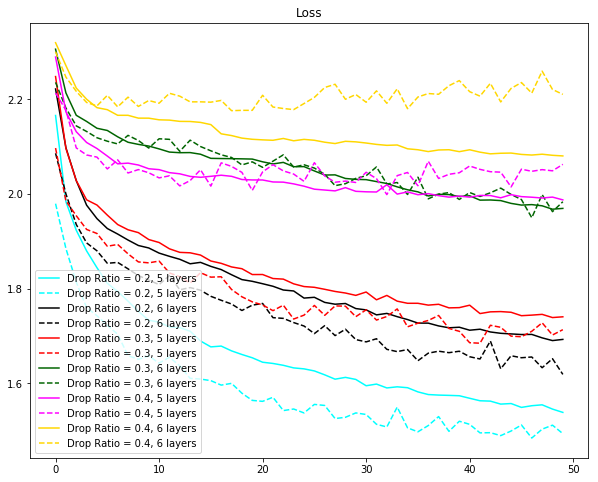

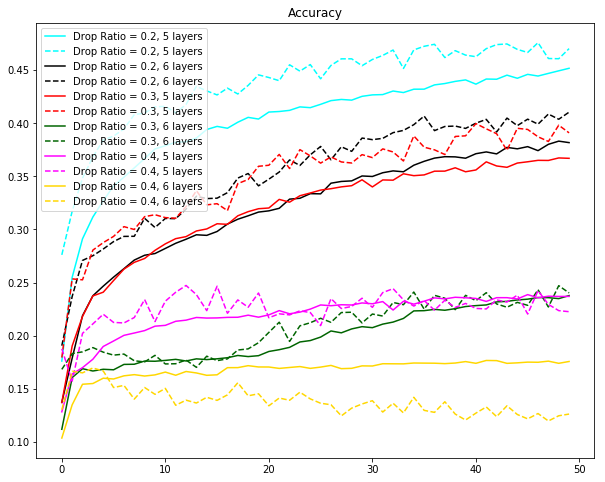

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ['aqua','black','red','darkgreen','fuchsia','gold']

plt.figure(figsize=(10, 8))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_loss'])),results[cond]['valid_loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])),results[cond]['train_acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_acc'])),results[cond]['valid_acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()
